In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.over_sampling import RandomOverSampler

In [2]:
# Consulta general del dataframe
def display_all(df):
    with pd.option_context("display.max_rows",1000 ,  "display.max_columns", 1000): 
        display(df)

In [3]:
# Función para identificar el porcentaje de valores nulos por columna
def percentage_nulls(df):
    number_nulls = pd.DataFrame(df.isnull().sum(),columns=['Total'])
    number_nulls['% nulls'] = round((number_nulls['Total'] / df.shape[0])*100,1)
    
    return number_nulls

In [4]:
# Función para generar contador de ciudades afectadas por el temblor
def contar_ciudades(location):
    paises = location.split(';')
    ciudades = [c.split(':') for c in paises]
    contador = 0 
    if len(ciudades) == 1:
        contador = len(ciudades[0][-1].split(','))
    else:
        for c in ciudades:
            contador += len(c[-1].split(','))
    
    return contador

In [5]:
# df_earthquakes_work.rename(columns = {'Focal Depth (km)':'Depth','Mag':'Magnitud','MMI Int':'MMI','Death Description':'Death_Cat','Injuries Description':'Injuries_Cat','Damage Description':'Damage_Cat'}, inplace=True)
# Funcion que renombra columnas
def rename_columns(df):
    columns_array = {'Focal Depth (km)':'Depth','Mag':'Magnitud','MMI Int':'MMI','Death Description':'Death_Cat','Injuries Description':'Injuries_Cat','Damage Description':'Damage_Cat'}
    df.rename(columns=columns_array, inplace = True)
    return df


In [6]:
# Función para rellenar NULOS de las columnas categoricas y la profundidad con la moda
def fill_nulls(df):
    # Rellena la profundidad con la moda de la profundidad
    df['Depth'].fillna(df['Depth'].mode().max(), inplace=True)

    # Se rellena con ceros los valores NAN de algunas columnas
    df['Magnitud'].fillna(0, inplace=True)
    df['Death_Cat'].fillna(0, inplace=True)
    df['Injuries_Cat'].fillna(0, inplace=True)
    df['Damage_Cat'].fillna(0, inplace=True)

    if df['Region'].isnull().sum() > 0:
        country = df[df['Region'].isnull()]['Country'].unique()
        for cnt in country:
            df['Region'].fillna(df[df['Country'] == cnt]['Region'].max(), inplace = True)


    return df



In [7]:
# Seleccion de columnas y registros
def filtra_df(df, axo=1930):
    df = df[(df['Year'] >= axo) & (df['Magnitud'] > 0)][['Year', 'Mo', 'Dy', 'Country', 'Region', 'Location Name', 'Latitude', 'Longitude', 'Depth', 'Magnitud', 'Death_Cat', 'Injuries_Cat', 'Damage_Cat','Density','IDH']]
    return df


In [8]:
# Generar columna con contador de ciudades afectadas por el sismo
def categoriza_ciudad(df):
    df['Ciudades'] = df['Location Name'].apply(contar_ciudades)
    df.drop(columns='Location Name', inplace=True)
    return df

In [9]:
# Preparar los conjuntos para entrenar los modelos
#'Latitude','Longitude'
def dataset_train(df, target='Death_Cat'):
    if target == 'Death_Cat':
        df = df[df['Death_Cat'] > 0][['Region','Depth','Magnitud','Death_Cat','Ciudades','Density','IDH']]
    elif target == 'Injuries_Cat':
        df = df[df['Injuries_Cat'] > 0][['Region','Depth','Magnitud','Injuries_Cat','Ciudades','Density','IDH']]
    elif target == 'Damage_Cat':
        df = df[df['Damage_Cat'] > 0][['Region','Depth','Magnitud','Damage_Cat','Ciudades','Density','IDH']]
    
    return df

In [10]:
def dataframe_transfor(df):
    #Renombrar columnas
    df = rename_columns(df)
    #Tratamiento de NULOS;
    df = fill_nulls(df)
    # Filtra y selecciona columnas
    df = filtra_df(df, 1990)
    # Crear columna con numero de Ciudades Afectadas
    df = categoriza_ciudad(df)
    return df


In [11]:
# Asigna los valores de densidad de poblacion e indice de desarrollo humano por pais y año
def asigna_sociodemo(df, df_sd):
    df['Density'] = 0
    df['IDH'] = 0

    for i in df_sd.index:
        axo = df_sd['Year'][i]
        country = df_sd['Country'][i]
        density = df_sd['Density'][i]
        idh = df_sd['IDH'][i]
        
        df.loc[(df['Year'] == axo) & (df['Country'] == country), 'Density'] = density
        df.loc[(df['Year'] == axo) & (df['Country'] == country), 'IDH'] = idh
    
    return df

In [12]:
# Extraccion datos fuente
df_earthquakes = pd.read_csv('..\Dataset\earthquakes-1500-2021.csv')
df_sociodemo = pd.read_csv('..\Dataset\socio_demografico.csv')

In [ ]:
df_earthquakes.select_dtypes(include=['float64', 'int']).describe()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

sns.distplot(
    df_earthquakes.Deaths,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Decesos', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(df_earthquakes.Deaths),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Decesos)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(df_earthquakes.Deaths),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Decesos)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [ ]:
df_earthquakes.select_dtypes(include=['float64', 'int']).columns

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = df_earthquakes.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop(['Mo', 'Dy', 'MMI Int', 'Deaths', 'Death Description','Injuries Description', 'Damage Description','Houses Destroyed', 'Houses Destroyed Description', 'Houses Damaged','Houses Damaged Description'])
columnas_numeric

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df_earthquakes,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [ ]:
columnas_numeric

In [ ]:
df_sociodemo.head()

In [13]:
# Asocia valores de densidad de poblacion e idh
df_earthquakes = asigna_sociodemo(df_earthquakes, df_sociodemo)

In [ ]:
# Consulta general de información de Dataframe       
df_earthquakes.head(10)

In [ ]:
df_earthquakes[['Death_Cat', 'Injuries_Cat','Damage_Cat']].describe()

In [14]:
# Transformación 
df_earthquakes = dataframe_transfor(df_earthquakes)
df_earthquakes.head(10)

,Year,Mo,Dy,Country,Region,Latitude,Longitude,Depth,Magnitud,Death_Cat,Injuries_Cat,Damage_Cat,Density,IDH,Ciudades
4095,1990,2.0,8.0,PHILIPPINES,170.0,9.755,124.694,26.0,6.6,2.0,3.0,1.0,203,0.593,4
4096,1990,2.0,20.0,JAPAN,30.0,34.706,139.252,14.0,6.4,0.0,0.0,0.0,327,0.818,1
4097,1990,2.0,28.0,USA,150.0,34.140,-117.700,5.0,5.5,0.0,1.0,3.0,26,0.865,3
4098,1990,3.0,3.0,FIJI,170.0,-22.122,175.163,33.0,7.6,0.0,0.0,0.0,0,0.000,1
4099,1990,3.0,4.0,PAKISTAN,60.0,28.925,66.331,10.0,6.1,1.0,1.0,2.0,0,0.000,3
4100,1990,3.0,25.0,COSTA RICA,100.0,9.919,-84.808,22.0,7.0,0.0,1.0,2.0,0,0.000,2
4101,1990,3.0,25.0,TAJIKISTAN,40.0,37.034,72.942,33.0,6.3,0.0,0.0,1.0,0,0.000,1
4102,1990,3.0,26.0,PHILIPPINES,170.0,9.253,125.606,39.0,5.5,1.0,1.0,1.0,203,0.593,1
4103,1990,4.0,2.0,UK,120.0,52.314,-2.985,18.0,4.7,0.0,0.0,1.0,0,0.000,2
4104,1990,4.0,5.0,USA TERRITORY,170.0,15.125,147.596,11.0,7.5,0.0,0.0,0.0,0,0.000,2


In [15]:
df_earthquakes_deaths = dataset_train(df_earthquakes,'Death_Cat')
df_earthquakes_injuries = dataset_train(df_earthquakes,'Injuries_Cat')
df_earthquakes_damage = dataset_train(df_earthquakes,'Damage_Cat')

In [ ]:
df_earthquakes_deaths.Death_Cat.value_counts()
# df_earthquakes_injuries.head(3)
# df_earthquakes_damage.head(3)

<AxesSubplot:>

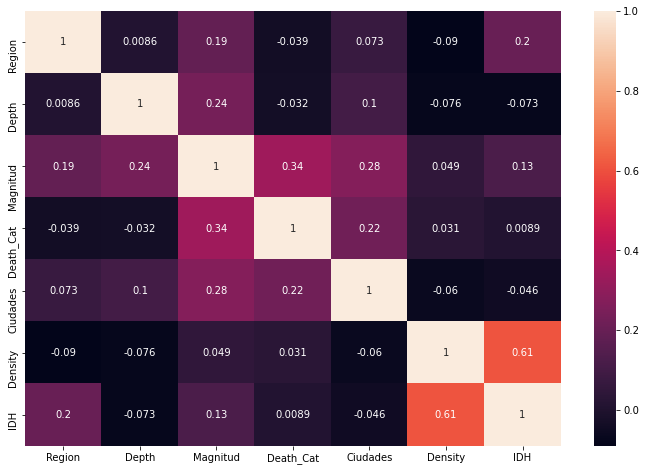

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(df_earthquakes_deaths.corr(), annot=True)

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_earthquakes_injuries.corr(), annot=True)

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_earthquakes_damage.corr(), annot=True)

## Proceso de modelado

In [26]:
# Separar los conjuntos (Target y variables predictoras)
X = df_earthquakes_deaths.drop(columns = ['Death_Cat'])
y = df_earthquakes_deaths['Death_Cat']

#Balanceando los conjuntos
ros = RandomOverSampler()
X_ros, y = ros.fit_resample(X, y)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_t = scaler.fit_transform(X_ros)

In [18]:
from collections import Counter
Counter(y).items()

dict_items([(2.0, 546), (1.0, 546), (3.0, 546), (4.0, 546)])

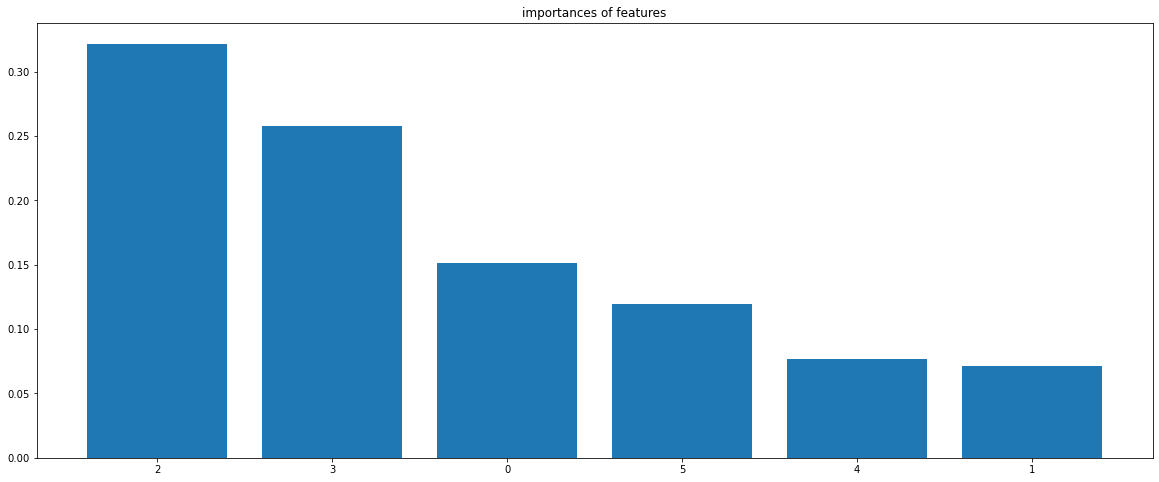

In [28]:
# Selección de características mediante Arbol de clasificación (Grafica)
tree_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=4)
tree_classifier.fit(X_t,y)
index = np.flipud(np.argsort(tree_classifier.feature_importances_))
score = tree_classifier.feature_importances_[index]

fig,ax = plt.subplots(figsize=(20,8))
plt.bar(range(len(index)),score,align='center')
plt.xticks(range(len(index)),index)
plt.title('importances of features')
plt.show()

In [ ]:
df_earthquakes_deaths.drop(columns = ['Death_Cat']).head(1)

In [29]:
#Creando set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.2, shuffle=True, random_state=50) 

# Entrenando el modelo
modelo_LR = LogisticRegression(penalty='l2',C=10, solver='newton-cg', multi_class = 'multinomial')
modelo_LR.fit(X_train, y_train)


LogisticRegression(C=10, multi_class='multinomial', solver='newton-cg')

In [30]:
print('Intercept: ',modelo_LR.intercept_)
print('Accuracy:', round(modelo_LR.score(X_test, y_test)*100,1))

Intercept:  [-0.23279909  0.31489564  0.21341653 -0.29551308]
Accuracy: 45.8


In [ ]:
y_predict = modelo_LR.predict(X_test)
confusion_matrix(y_test, y_predict)

In [ ]:
accuracy_RL = accuracy_score(y_true=y_test, y_pred=y_predict, normalize=True)
print(f'El accuracy test es de: {round(accuracy_RL * 100,1)} %')

In [ ]:
df_pred_Deaths = pd.DataFrame({'Original': y_test,'Predicha':y_predict})
df_pred_Deaths

In [31]:
# Utilizando Arboles de decisión para validar si da mejores resultados que RegressionLogistics
modelo_DT = DecisionTreeClassifier(max_depth = 8, criterion = 'gini', random_state = 123)
modelo_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=123)

Profundidad del árbol: 8
Número de nodos terminales: 70


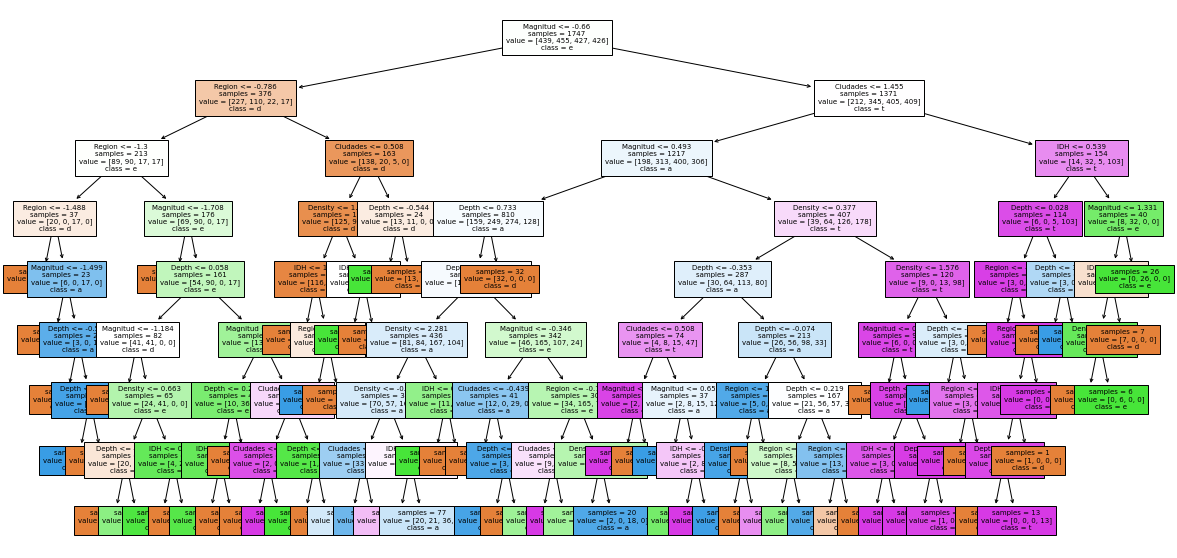

In [37]:
labels = X.columns.to_list()
fig, ax = plt.subplots(figsize=(20, 10))

print(f"Profundidad del árbol: {modelo_DT.get_depth()}")
print(f"Número de nodos terminales: {modelo_DT.get_n_leaves()}")

plot = plot_tree( decision_tree = modelo_DT, feature_names = labels, class_names = 'deaths_category', filled = True, 
impurity= False, fontsize= 7, ax = ax)

In [ ]:
y_predict_DT = modelo_DT.predict(X_test)
df_pred_Deaths_DT = pd.DataFrame({'Actual':y_test,'Predicted':y_predict_DT})
df_pred_Deaths_DT['Validacion'] = abs(df_pred_Deaths_DT['Actual'] - df_pred_Deaths_DT['Predicted'])
correctos = df_pred_Deaths_DT[df_pred_Deaths_DT['Validacion'] == 0]['Validacion'].count()
total = df_pred_Deaths_DT.shape[0]
incorrectos = total - correctos
porcentaje = (correctos / total) * 100
print(f'Correctos: {correctos}')
print(f'Incorrectos: {incorrectos}')
print(f'Precision: {porcentaje}')


In [ ]:
confusion_matrix(y_test, y_predict_DT)

In [ ]:
accuracy_DT = accuracy_score(y_true=y_test, y_pred=y_predict_DT, normalize=True)
print(f'El accuracy test es de: {accuracy_DT * 100} %')

In [ ]:
# Podado de arbol para identificar el mejor nivel por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = 8,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True)

grid.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [ ]:
grid.best_params_

In [ ]:
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

In [ ]:
predicciones = modelo_final.predict(X = X_test)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True)
print(f"El accuracy de test es: {100 * accuracy} %")

In [ ]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': labels,'importancia': modelo_final.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

In [ ]:
predicciones = modelo_DT.predict_proba(X = X_test)
predicciones